In [1]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegem1d import DigFilter
%matplotlib inline
import matplotlib 
matplotlib.rcParams["font.size"] = 14
matplotlib.rcParams["image.cmap"] = "jet"

In [2]:
import numpy as np
import scipy.sparse as sp
from scipy.constants import mu_0

def BiotSavartFun(mesh, r_pts, component = 'z'):
    """
        Compute systematrix G using Biot-Savart Law


        G = np.vstack((G1,G2,G3..,Gnpts)

        .. math::

    """
    if r_pts.ndim == 1:
        npts = 1
    else:
        npts = r_pts.shape[0]
    e = np.ones((mesh.nC, 1))
    o = np.zeros((mesh.nC, 1))
    const = mu_0/4/np.pi
    if mesh._meshType == "CYL":
        G = np.zeros((npts, mesh.nC))        
    else:
        G = np.zeros((npts, mesh.nC*3))

    for i in range(npts):
        if npts == 1:
            r_rx = np.repeat(Utils.mkvc(r_pts).reshape([1,-1]), mesh.nC, axis = 0)
        else:
            r_rx = np.repeat(r_pts[i,:].reshape([1,-1]), mesh.nC, axis = 0)
        r_CC = mesh.gridCC
        r = r_rx-r_CC
        r_abs = np.sqrt((r**2).sum(axis = 1))
        rxind = r_abs==0.
        # r_abs[rxind] = mesh.vol.min()**(1./3.)*0.5
        r_abs[rxind] = 1e20
        Sx = const*Utils.sdiag(mesh.vol*r[:,0]/r_abs**3)
        Sy = const*Utils.sdiag(mesh.vol*r[:,1]/r_abs**3)
        Sz = const*Utils.sdiag(mesh.vol*r[:,2]/r_abs**3)
        
        if mesh._meshType == "CYL":
            if component == 'x':
                G_temp = np.hstack((e.T*Sz))
            elif component == 'z':
                G_temp = np.hstack((-e.T*Sx))                        
        else:
            if component == 'x':
                G_temp = np.hstack(( o.T,     e.T*Sz, -e.T*Sy))
            elif component == 'y':
                G_temp = np.hstack((-e.T*Sz,  o.T,     e.T*Sx))
            elif component == 'z':
                G_temp = np.hstack(( e.T*Sy, -e.T*Sx,  o.T   ))            
        G[i,:] = G_temp
    return G

In [3]:
# eta, tau, c = 0.1, 0.01, 0.5
cs, ncx, ncz, npad = 10., 25, 20, 18
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sigmaInf = np.ones(mesh.nC) * 0.001
airind = mesh.gridCC[:,2]>0.
# layerind = np.logical_and(mesh.gridCC[:,2]<-50, mesh.gridCC[:,2]>-100.)
layerind = (np.logical_and(mesh.gridCC[:,2]<-50, mesh.gridCC[:,2]>-100.)) & (mesh.gridCC[:,0]<100.)
sigmaInf[airind] = 1e-8
sigmaInf[layerind] = 0.01
eta = np.zeros(mesh.nC)
eta[layerind] = 0.5
tau = np.ones(mesh.nC) * 0.005
c = np.ones(mesh.nC) * 0.5
wiresEM = Maps.Wires(('sigmaInf', mesh.nC), ('eta', mesh.nC), ('tau', mesh.nC), ('c', mesh.nC))
m = np.r_[sigmaInf, eta, tau, c]

In [4]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
rx = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51), 'z')
src = EM.TDEM.Src.CircularLoop([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc)
survey = EM.TDEM.Survey([src])
prb_em = EM.TDEM.Problem3D_e(mesh, sigmaMap=Maps.IdentityMap(mesh))
# prb_em.verbose = True
prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
# prb_em.timeSteps = [(1e-06, 5), (5e-06, 10), (1e-05, 10), (5e-05, 10), (1e-04, 10), (5e-04, 10), (1e-03, 10)]
prb_em.Solver = PardisoSolver
prb_em.pair(survey)
F = prb_em.fields(sigmaInf)
data = survey.dpred(sigmaInf, f=F)

In [6]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
dt = 1e-5
# dt = 1.47e-3
rx_ramp = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51)+dt, 'z')
src_ramp = EM.TDEM.Src.CircularLoop([rx_ramp], waveform=EM.TDEM.Src.RampOffWaveform(offTime=dt), loc=srcloc)
survey_ramp = EM.TDEM.Survey([src_ramp])
prb_em_ramp = EM.TDEM.Problem3D_e(mesh, sigmaMap=Maps.IdentityMap(mesh))
# prb_em_ramp.verbose = True
prb_em_ramp.timeSteps = [(dt/10, 10), (1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_em_ramp.Solver = PardisoSolver
prb_em_ramp.pair(survey_ramp)
# m = np.r_[sigmaInf, etavec, np.log(tauvec), cvec]
F_ramp = prb_em_ramp.fields(sigmaInf)
data_ramp = survey_ramp.dpred(sigmaInf, f=F_ramp)
cur = []
for t in prb_em_ramp.times:
    cur.append(src_ramp.waveform.eval(t))
cur = np.hstack(cur)

In [7]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
tpeak = 2.73e-3
# t0 = 4.2e-3
t0 = tpeak + dt
rx_vtem = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(2e-5), np.log10(0.009), 51)+t0, orientation='z')
src_vtem = EM.TDEM.Src.CircularLoop([rx_vtem], waveform=EM.TDEM.Src.VTEMWaveform(offTime=t0, peakTime=tpeak, a=3.), loc=srcloc)
survey_vtem = EM.TDEM.Survey([src_vtem])
prb_em_vtem = EM.TDEM.Problem3D_e(mesh, sigmaMap=Maps.IdentityMap(mesh))
# prb_em_vtem.verbose = True
prb_em_vtem.timeSteps = [(tpeak/10, 10), ((t0-tpeak)/10, 10), (1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
prb_em_vtem.Solver = PardisoSolver
prb_em_vtem.pair(survey_vtem)
F_vtem = prb_em_vtem.fields(sigmaInf)
data_vtem = survey_vtem.dpred(sigmaInf, f=F_vtem)
cur = []
for t in prb_em_vtem.times:
    cur.append(src_vtem.waveform.eval(t))
cur = np.hstack(cur)

In [8]:
eCC = mesh.aveE2CCV*F[src, 'eSolution', :]
eCC_ramp = mesh.aveE2CCV*F_ramp[src_ramp, 'eSolution', :]
eCC_vtem = mesh.aveE2CCV*F_vtem[src_vtem, 'eSolution', :]

In [9]:
def geteref(eCC, option=None, tInd=0):
    ntime = eCC.shape[1]
    if option == "max":
        print (">> Use maximum")
        inds = np.argmax(abs(eCC), axis=1)
        inds_max = Utils.sub2ind(eCC.shape, np.c_[np.arange(mesh.nC), inds])
        emax = Utils.mkvc(eCC)[inds_max]    
    else:
        emax = eCC[:,tInd]
    return emax

In [10]:
def geterefE(e, option=None, tInd=0):
    ntime = e.shape[1]
    if option == "max":
        print (">> Use maximum")
        inds = np.argmax(abs(e), axis=1)
        inds_max = Utils.sub2ind(e.shape, np.c_[np.arange(mesh.nE), inds])
        emax = Utils.mkvc(e)[inds_max]    
    else:
        emax = e[:,tInd]
    return emax

In [11]:
# eref = geteref(eCC, option="max")
# eref_ramp = geteref(eCC_ramp, option=None, tInd=10) 
# eref_vtem = geteref(eCC_vtem, option=None, tInd=20) 
eref = geterefE(F[src, 'eSolution', :], option="max") 
eref_ramp = geterefE(F_ramp[src_ramp, 'eSolution', :], option=None, tInd=10) 
eref_vtem = geterefE(F_vtem[src_vtem, 'eSolution', :], option=None, tInd=20) 

>> Use maximum


/Users/sgkang/anaconda2/envs/simpeg/lib/python3.6/site-packages/matplotlib/axes/_base.py:2966: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


(1e-06, 0.0001)

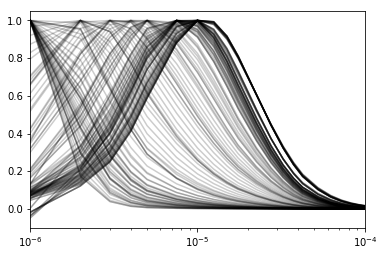

In [12]:
e = F[src,'eSolution', :]
z = mesh.vectorCCz[np.logical_and(mesh.vectorCCz < 0., mesh.vectorCCz > -200.)]
x = mesh.vectorCCx[mesh.vectorCCx < 100.]
xyz = Utils.ndgrid(x, np.r_[0.], z)
rxinds = Utils.closestPoints(mesh, pts=xyz, gridLoc='N')
for rxind in rxinds:
    plt.plot(prb_em.times[1:], e[rxind,1:].flatten() / eref[rxind], 'k', alpha=0.2)
plt.xscale('log')
plt.xlim(0, 1e-4)

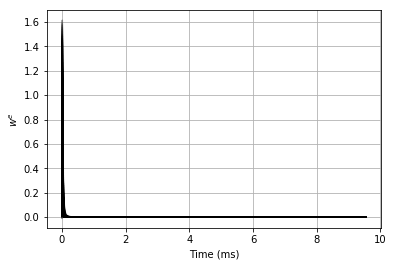

In [13]:
fig = plt.figure()
e = F_ramp[src_ramp,'eSolution', :]
z = mesh.vectorCCz[np.logical_and(mesh.vectorCCz < 0., mesh.vectorCCz > -200.)]
x = mesh.vectorCCx[mesh.vectorCCx < 200.]
xyz = Utils.ndgrid(x, np.r_[0.], z)
rxinds = Utils.closestPoints(mesh, pts=xyz, gridLoc='N')
for rxind in rxinds:
    plt.plot(prb_em_ramp.times[1:]*1e3, e[rxind,1:].flatten() / eref_ramp[rxind], 'k', alpha=0.1)
plt.xscale('linear')
plt.xlabel('Time (ms)')
plt.ylabel('$w^e$')
plt.grid(True)
# plt.xlim(0, 1e-4)

In [14]:
eref0 = mesh.aveE2CCV*src._aSrc(prb_em_vtem)

In [15]:
prb_em_ramp.times[10]

1.0000000000000004e-05

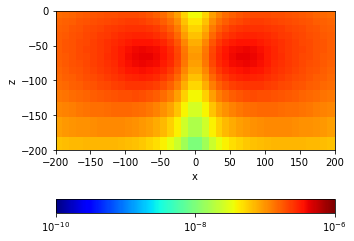

In [16]:
fig, ax  = plt.subplots(1, 1, figsize = (5,6))
temp = mesh.aveE2CCV*F_ramp[src_ramp,'eSolution', 16]
temp[temp<1e-10] = 1e-10
dat = mesh.plotImage(np.log10(abs(temp)), grid=False, mirror=True, ax=ax, clim=(-10, -6))
cb = plt.colorbar(dat[0], orientation="horizontal", format="10$^{%.0f}$", ticks=[-10, -8, -6])
plt.xlim(-200, 200)
plt.ylim(-200, 0)
plt.gca().set_aspect('equal')
# plt.tight_layout()

In [17]:
import SimPEG

In [18]:
# plt.colorbar((mesh.plotImage(np.log10(abs(eref_ramp)/abs(eref_ramp).max()), grid=False, mirror=True, clim=(-6, 0)))[0])
# plt.xlim(-300, 300)
# plt.ylim(-300, 0)
# plt.gca().set_aspect('equal')

In [19]:
# plt.colorbar((mesh.plotImage(np.log10(abs(eref_vtem)/abs(eref_vtem).max()), grid=False, mirror=True, clim=(-6, 0)))[0])
# plt.xlim(-300, 300)
# plt.ylim(-300, 0)
# plt.gca().set_aspect('equal')

In [20]:
def getJ(mesh, srcloc, rxloc, sigma, eref):
    Meinv = mesh.getEdgeInnerProduct(invMat=True)
    MeDeriv = mesh.getEdgeInnerProductDeriv(np.ones(mesh.nC))
#     MeDeriv = prb_em.MeSigmaDeriv
    S_temp = MeDeriv(eref)*Utils.sdiag(sigma)
#     S_temp = MeDeriv(eref)
#     S_temp = MeDeriv((mesh.aveE2CCV.T*eref))*Utils.sdiag(sigma)
    G_temp = BiotSavartFun(mesh, rxloc, component = 'z')    
    J = - Utils.mkvc(G_temp*mesh.aveE2CCV*Meinv*S_temp)
    return J

In [21]:
def getpetaOff_rampoff(eta, tau, c, time, dt):
    peta = np.zeros_like(time)
    peta = eta*(np.exp(-(time/tau)**c))
    peta -= eta*(np.exp(-((time+dt)/tau)**c))
    return peta
def getpetaI_rampoff(eta, tau, c, time, dt):
    offinds = time > 0.
    peta = np.zeros_like(time)
    m = eta*c/(tau**c)
    peta = m*time**(c-1.)*np.exp(-(time/tau)**c)
    peta -= m*(time+dt)**(c-1.)*np.exp(-((time+dt)/tau)**c)    
    return peta
def getpetaI_ramponoff(eta, tau, c, time, t1, t2, t3):
    offinds = time > 0.
    peta = np.zeros_like(time)
    m = eta*c/(tau**c)
    peta = m*time**(c-1.)*np.exp(-(time/tau)**c)
    peta -= m*(time+t1)**(c-1.)*np.exp(-((time+t1)/tau)**c)    
    peta -= m*(time+t2)**(c-1.)*np.exp(-((time+t2)/tau)**c)    
    peta += m*(time+t3)**(c-1.)*np.exp(-((time+t3)/tau)**c)    
    return peta

In [22]:
ntime = rx.times.size
# peta = np.ones((mesh.nC, ntime))
peta_ramp = np.ones((mesh.nC, ntime))
peta_vtem = np.ones((mesh.nC, ntime))

In [23]:
# J = getJ(mesh, srcloc, rxloc, sigmaInf, eref)
J_ramp = getJ(mesh, srcloc, rxloc, sigmaInf, eref_ramp)
# for itime, time in enumerate(rx.times):
#     peta[:,itime] = getpetaI_rampoff(eta, tau, c, time, 1.2e-5)
for itime, time in enumerate(rx.times):
    peta_ramp[:,itime] = getpetaI_rampoff(eta, tau, c, time, dt)
t1, t2, t3 = dt, t0-0.001365, t0
for itime, time in enumerate(rx.times):
    peta_vtem[:,itime] = getpetaI_ramponoff(eta, tau, c, time, t1, t2, t3)    

In [24]:
np.unique(eta)

array([0. , 0.5])

In [25]:
np.unique(tau)

array([0.005])

In [26]:
np.unique(c)

array([0.5])

In [27]:
np.unique(sigmaInf)

array([1.e-08, 1.e-03, 1.e-02])

In [28]:
np.save("J", J_ramp)

In [29]:
t1, t2, t3

(1e-05, 0.001375, 0.00274)

In [30]:
# ip_approx = -J_ramp.dot(peta)
ip_ramp_approx = -J_ramp.dot(peta_ramp)
ip_vtem_approx = -J_ramp.dot(peta_vtem)

In [31]:
# mesh.plotImage(peta[:,20], grid=True, mirror=True)
# plt.xlim(-300, 300)
# plt.ylim(-300, 300)
# plt.gca().set_aspect('equal')

In [30]:
rx.times

array([  2.00000000e-05,   2.25992614e-05,   2.55363308e-05,
         2.88551108e-05,   3.26052096e-05,   3.68426828e-05,
         4.16308710e-05,   4.70413468e-05,   5.31549847e-05,
         6.00631698e-05,   6.78691638e-05,   7.66896488e-05,
         8.66564710e-05,   9.79186121e-05,   1.10644416e-04,
         1.25024104e-04,   1.41272620e-04,   1.59632844e-04,
         1.80379218e-04,   2.03821856e-04,   2.30311170e-04,
         2.60243117e-04,   2.94065111e-04,   3.32282716e-04,
         3.75467199e-04,   4.24264069e-04,   4.79402730e-04,
         5.41707381e-04,   6.12109336e-04,   6.91660945e-04,
         7.81551325e-04,   8.83124136e-04,   9.97897661e-04,
         1.12758751e-03,   1.27413224e-03,   1.43972238e-03,
         1.62683312e-03,   1.83826135e-03,   2.07716744e-03,
         2.34712250e-03,   2.65216175e-03,   2.99684483e-03,
         3.38632399e-03,   3.82642105e-03,   4.32371449e-03,
         4.88563770e-03,   5.52059018e-03,   6.23806303e-03,
         7.04878086e-03,

In [32]:
data = np.load("data.npy")
data_ramp = np.load("data_ramp.npy")
data_vtem = np.load("data_vtem.npy")

data_em = np.load("dataem.npy")
data_em_ramp = np.load("dataem_ramp.npy")
data_em_vtem = np.load("dataem_vtem.npy")
ip = data - data_em
ip_ramp = data_ramp - data_em_ramp
ip_vtem = data_vtem - data_em_vtem

In [33]:
data_ramp_approx = data_em_ramp + ip_ramp_approx
data_vtem_approx = data_em_vtem + ip_vtem_approx

NameError: name 'data_em_ramp' is not defined

In [33]:
# plt.loglog(rx.times, -data_ramp, 'k')
# plt.loglog(rx.times, data_ramp, '--k')
# plt.loglog(rx.times, -data_em_ramp, 'b-')
# plt.loglog(rx.times, ip_ramp, 'r-')
# plt.plot(rx.times, ip_ramp_approx, 'r.')

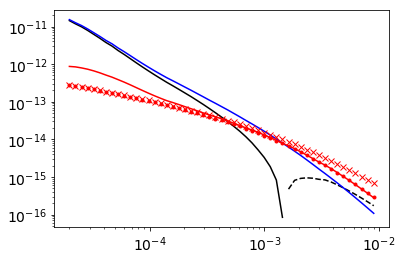

In [34]:
plt.loglog(rx.times, -data_vtem, 'k')
plt.loglog(rx.times, data_vtem, '--k')
plt.loglog(rx.times, -data_em_vtem, 'b-')
plt.loglog(rx.times, ip_vtem, 'r-')
plt.plot(rx.times, ip_vtem_approx, 'r.')
plt.plot(rx.times, ip_ramp_approx, 'rx')

In [35]:
out = getpetaI_rampoff(0.5, 0.005, 0.5, rx.times, dt)

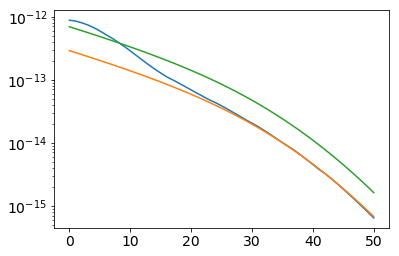

In [36]:
plt.semilogy(ip_ramp)
plt.semilogy(ip_ramp_approx)
plt.semilogy(out*1e-15)

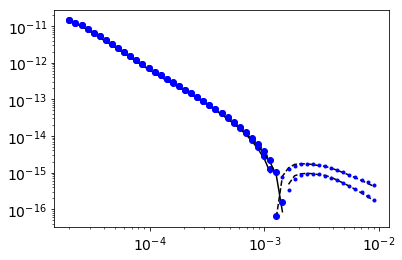

In [37]:
plt.loglog(rx.times, -data_ramp, 'k')
plt.loglog(rx.times, data_ramp, '--k')
plt.loglog(rx.times, -data_ramp_approx, 'bo')
plt.loglog(rx.times, data_ramp_approx, 'b.')

plt.loglog(rx.times, -data_vtem, 'k')
plt.loglog(rx.times, data_vtem, '--k')
plt.loglog(rx.times, -data_vtem_approx, 'bo')
plt.loglog(rx.times, data_vtem_approx, 'b.')
